# **Assignment 2: Intro to Sound Event Classification**
### Due: Thursday, February 19th, midnight EST
### Quiz date: Tuesday, February 24th in-class

CS-GY 6933: Machine Listening Spring 2026

Below you will find a mix of coding questions and writing questions to familiarize you with the basics of statistical learning and sound event classification. Refer to lecture 4 slides for guidance throughout.

The assignment will have two parts:

1. Part 1: **Tutorial**: getting used to working with a simple dataset and setting up a statistical learning problem in Python. This portion is not worth any points and typically will not have anything to "fill-in".

2. Parts 2-3: **Problem solving**: core part of the assignment, with two-part multi-step problem solving tasks. This will be worth 5 points total. The in-class quiz about the assignment will also be worth 5 points.

All pieces of code/text you need to complete will be indicated with ❗ TODO ❗.

When you complete the assignment, please evaluate the notebook so that all results are shown/printed, download it as a .ipynb file, and submit the notebook file **and** a link to the shared Colab in Brightspace.

🚨 Please turn off auto-complete in Colab via Settings -> AI Assistance -> Show AI-powered inline completions.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import librosa
from tqdm import tqdm
import os
import IPython
import glob

# **Part 1:** Statistical learning tutorial *[0 pts]*


### **1.1** Loading data and basic manipulations 🐧
For this first part, we will work with non-audio; just a simple dataset that will help to get you familiar with working with data in Python and setting up a simple statistical learning model. To start, download the awesome **penguins** dataset from this [link](https://github.com/mwaskom/seaborn-data/blob/master/penguins.csv) as a CSV file, by running the `wget` command below.

The dataset consists of 7 columns:

* `species`: penguin species (Chinstrap, Adélie, or Gentoo)
* `island`: island name (Dream, Torgersen, or Biscoe) in the Palmer Archipelago (Antarctica)
* `bill_length_mm`: bill length (mm)
* `bill_depth_mm`: bill depth (mm)
* `flipper_length_mm`: flipper length (mm)
* `body_mass_g`: flipper length (mm)
* `sex`: penguin sex





In [ ]:
# Download the Penguin dataset CSV:
# If using windows, best to download the raw file -> save as .csv
!wget -O penguins.csv https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv

In [ ]:
# Load the dataset into a Pandas DataFrame
# Print the first 5 rows of the dataset
df = pd.read_csv('penguins.csv')
df.head(5)

In [ ]:
# Filter out rows that have any NaN values.
# Print the number of samples in the dataset before and after filtering.
print(f'Number of samples before filtering: {len(df)}')
df = df.dropna()
print(f'Number of samples after filtering: {len(df)}')

In [ ]:
# Print the number of samples per species
df['species'].value_counts()

In [ ]:
# Create a DataFrame of the mean flipper length by species and sex within each species and display it
df_mean = df.groupby(['species', 'sex'])['flipper_length_mm'].mean()
df_mean

In [ ]:
# Add a column to the original DataFrame that maps the 3 species types to the labels [0,1,2]
# Name this column "species_label"
# Print the first 5 rows of the updated DataFrame
df['species_label'] = df['species'].map({'Adelie': 0, 'Chinstrap': 1, 'Gentoo': 2})
df.head(5)

In [ ]:
# Exploratory data plot using matplotlib or seaborn
# Plot a scatter plot with flipper length on the x-axis, bill-length on the y-axis, colored by species
plt.scatter(df['flipper_length_mm'], df['bill_length_mm'], c=list(df['species_label']))
plt.xlabel('Flipper Length (mm)')
plt.ylabel('Bill Length (mm)')
plt.title('Flipper Length vs. Bill Length by Species')
plt.show()

### **1.2** Data preprocessing and splitting
We will use flipper length and bill length as the continuous features, and species as the target (but use `species_label`) for training a simple model. First we will split the data into a training and testing set. After splitting the data, we need to normalize or standardize the data in some way because the scale of data across features differs, use **min-max normalization**, defined as $x' = \frac{x - min(x)}{max(x) - min(x)}$ We won't show the code here exactly, since you'll be writing your own a bit later.



In [ ]:
# Assign the feature data , which should be a numpy array size (333,2) to `X`
# Assign the target data to `y`, which should be a numpy array shape (333,)
X = np.array(df[['flipper_length_mm', 'bill_length_mm']])
y = np.array(df['species_label'])

# Split the data into training and test sets using scikit-learn's train_test_split
# We will use cross validation to internally split the training set into train-val.
# Use 80% of the data for train, 20% for test for this experiment
# Hint: pass `stratify=y` to make sure your splits are balanced in terms of species class
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y,random_state=42)

# Let's check out the size of the splits
print('Train samples: ',  len(X_train))
print('Test samples: ', len(X_test))

In [ ]:
# Use the training data statistics to min-max normalize each feature
# Important! Normalize the test features using the statistics from the training set
# < Not including the code here because you'll need to implement it later, but just a tip! >

In [ ]:
# Print the number of samples per class in each of the data splits
# Ensure that classes are proportionately balanced across splits
print(f'Number of samples in train set: {len(X_train)}')
print(f'Number of samples in test set: {len(X_test)}')

print(f'Number of samples in train set per class: {np.unique(y_train, return_counts=True)[1]})')
print(f'Number of samples in test set per class: {np.unique(y_test, return_counts=True)[1]})')

### **1.3** Basic model training and hyperparameter tuning
Now we'll be training a model to predict species given your features.
We will use `scikit-learn`'s implementation of **[Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)** here. Check out the documentation for lots of helpful info on the specific parameters for this method.

We will first explore the use of regularization weighting (lambda) **hyperparameter** as discussed in class.
To select the best parameter for lambda, we'll **cross-validation**. Once we have found the best value for lambda, train one final model using those parameters and evaluate on the test set.

In [ ]:
# Train a logistic regression model to predict penguin species using scikit-learn
# Use 5-fold cross validation to find the best combination of regularization type and weight of regularization (lambda)
# Use penalty = 'l2'
lambdas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
penalty = 'l2'
for lam in lambdas:
    log_reg = LogisticRegression(C=1/lam, penalty=penalty, max_iter=1000)
    scores = cross_val_score(log_reg, X_train, y_train, cv=5)
    print(f'Logistic Regression (C={lam}), (Penalty={penalty}): Avg. CV Accuracy = {np.mean(scores):.4f}')

Lastly, **evaluate** the best performing combinations of both models on the test set:

In [ ]:
log_reg = LogisticRegression(C=1/0.01, penalty='l2', solver='liblinear', max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f'Logistic Regression Test Accuracy: {log_reg.score(X_test, y_test):.4f}')

# **Part 2:** Sound event classification: linear vs. logarithmmic-frequency representations [*3.5 pts]*






## Overview
In this section, you will build on your STFT experience from the previous assignment and move into applying this to more realistic audio scenarios using a key task in machine listening: **sound event classification**. You will implement two one vs. rest binary classifiers for a pitch classification task. Importantly, we will be experimenting with two types of time-frequency representations discussed in class: **linear and log-frequency spectrograms**.



## Dataset
We have curated a subset of the [Nsynth](https://magenta.withgoogle.com/datasets/nsynth) musical note dataset for you to use in this section. A few points about the dataset (read more details on the website):
- The dataset file is `nsynth_high_subset.tar.gz`.
- The dataset contains musical notes across 5 pitch classes and 3 instruments. For this section, we care about **pitch** classification, not instrument classification.
- The clips are 4 seconds long, at a sample rate of 16kHz.
- There is not a metadata file. Metadata information is derived from the audio filenames. e.g. `mallet_electronic_011-106-050.wav`. The pitch information is encoded in the middle digit: `106` in this example. That means a note with a **MIDI** value of 106. You can find conversions of MIDI to Hz with a quick search. The instrument class is the first string chunk ("mallet" in this example).


In [ ]:
# Untar the dataset
!tar -xzvf nsynth_high_subset.tar.gz

# windows:
# import tarfile
# with tarfile.open("nsynth_high_subset.tar.gz", "r:gz") as tar:
# 	tar.extractall()

In [ ]:
# ❗ TODO ❗ Load an example audio file and play it

In [ ]:
# ❗ TODO ❗ Using the filename, parse out the MIDI value
# Use librosa.midi_to_hz to convert this to Hz

## **2.1**: Implementing your linear and log-frequency spectrograms *[2.5 pts]*

#### **Deliverables:**
- Complete `spec_processor_nsynth`, which will use a couple of core methods:
    - `get_linear_power_spec`: Implement a linear-frequency spectrogram.
    - `get_log_filterbank`: Implement a log filterbank from scratch.
        - ⚠️ You may use librosa.stft, but **for the log-scaled spectrogram, you must implement the log filterbank from scratch**. Any numpy methods are allowed, but no further librosa methods should be used (except for loading the audio). ⚠️
    - `apply_filterbank`: Apply your log filterbank to get a linear spectrogram.
- Plot the log filterbank.
- Plot a linear vs. log-frequency scaled spectrogram for a sample file in the dataset.

----

A couple of 💡hints💡 for the log-frequency spectrogram:
- Follow slide 37-38 as closely as possible for this implementation. This will include two core pieces at a high-level:
    - Getting the log-scaled center frequencies of the filterbanks
    - Using those center frequencies to build triangular filters on the FFT grid given the center frequencies.
- Implement triangular filters as the windows mentioned in the slides, where triangular filters peak at a center frequency and drop to zero at the centers of its neighbors.
- Use helper functions to avoid overloading some of the more substantial methods.


In [ ]:
# ❗ TODO ❗
def get_linear_power_spec(y: np.ndarray,
                          win_length: int,
                          hop_length: int) -> np.ndarray:
    """
    Compute the linear-frequency power spectrogram of an audio signal.
    You may use librosa and/or numpy for this - does not need to be from scratch.

    Args:
        y (np.ndarray, shape (N,)): Time-domain audio signal.
        win_length (int): FFT size / window length (number of samples per frame).
        hop_length (int): Hop length between consecutive frames (in samples).

    Returns:
        S (np.ndarray, shape (K, T)): Linear-frequency power spectrogram.
            - K = win_length//2 + 1 frequency bins
            - T = number of time frames
    """

    S = None
    return S

In [ ]:
# ❗ TODO ❗
def get_log_filterbank(
    sr: int,
    n_fft: int,
    B: int = 84,
    fmin: float = 50.0,
    fmax: float | None = None,
    bins_per_octave: int = 12,
    normalize: bool = True,
) -> np.ndarray:
    """
    Creates a log-frequency filterbank matrix using triangular windows.

    This filterbank uses geometrically spaced center frequencies to mimic
    musical octaves and semitones. Each filter is a triangle that peaks at
    a center frequency and drops to zero at the centers of its neighbors.

    Args:
        sr (int): Sampling rate (Hz)
        n_fft (int): Window length used in the STFT.
        B (int): The number of output frequency bands (filters). Defaults to 84, for a 7-octave range.
        fmin (float): The minimum frequency for the first filter (Hz).
        fmax (float | None): The maximum frequency (Hz). If None, uses sr/2.
        bins_per_octave (int): The density of filters (e.g., 12 for semitones).
        normalize (bool): If True, normalize each filter to sum to 1.

    Returns:
        F (np.ndarray): Filterbank matrix of shape (B, n_fft // 2 + 1) - AKA num_filters x num_frames
            Note! This returns the filterbank itself, not filterbank applied to a spectrogram.
        center_freqs (np.ndarray): Center frequencies of each filter in Hz. Shape B.
    """

    F = None
    center_freqs = None
    return F, None



In [ ]:
# ❗ TODO ❗
def apply_filterbank(F: np.ndarray, power_spec: np.ndarray) -> np.ndarray:
    """
    Apply filterbank to a linear power spectrogram.

    Args:
        F: filterbank, shape (B, K), where K = n_fft//2 + 1
        power_spec: linear power spectrogram, shape (K, T)

    returns:
        np.ndarray: Filterbank applied to power spectrogram.
        Shape (B, T).
    """
    X_log = None
    return X_log


#### Plot your log-scaled filterbank
Use the built-in function below to plot your log-scaled filterbank using some reasonable parameters. Your plot should have a similar idea as the log2 filterbank image in slide 45 (but will not be exactly the same, this depends on many hyperparameters used).

In [ ]:
# BUILT-IN: Filterbank plotting code.

def plot_filterbank(F: np.ndarray, title: str, sr: int, n_fft: int, ax=None):
    """
    Visualize a filterbank matrix.

    Parameters:
        F (np.ndarray): Filterbank matrix of shape (B, K),
            where B is number of filters and K = n_fft//2 + 1.
        title (str): Title for the plot.
        sr (int): Sampling rate (Hz).
        n_fft (int): FFT size used to compute frequency bins.
        ax (matplotlib.axes.Axes, optional): Existing axis to plot on.

    Returns:
        ax (matplotlib.axes.Axes): Axis containing the filterbank plot.
    """

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 4))

    freqs_hz = np.fft.rfftfreq(n_fft, d=1.0/sr) # d is sample spacing (inverse of sr)
    extent = [freqs_hz[0], freqs_hz[-1], 0, F.shape[0]]

    im = ax.imshow(
        F,
        aspect="auto",
        origin="lower",
        extent=extent,
        interpolation="nearest",
    )
    ax.set_title(title)
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Filter index")
    plt.colorbar(im, ax=ax, label="Weight")

    if ax is None:
        plt.show()

    return ax

In [ ]:
# ❗ TODO ❗ Plot your log-filterbank.

#### Put the pieces together!
Complete one last method here to pull the pieces together. Plug your methods above into this one to get spectrogram features given an input audio waveform, STFT parameters, and a type of frequency scaling.

In [ ]:
# ❗ TODO ❗
def spec_processor_nsynth(
    audio_path: str,
    spec_type: str,
    win_length: int,
    hop_length: int,
    sr: int = 16000) ->  np.ndarray:

    """
    Extracts time-frequency features from an audio file for pitch classification.

    This processor supports three representation types: Linear-frequency STFT,
    Log-frequency filterbanks.

    Args:
        audio_path (str): File path to the .wav audio sample.
        spec_type (str): The type of feature to extract based on frequency-scaling.
            Must be one of ['linear', 'log'].
        win_length (int): The number of samples per analysis window.
        hop_length (int): The number of samples between successive frames.
        sr (int): The sampling rate to use when loading audio.

    Returns:
        np.ndarray: A 2D feature matrix of shape (F, T), where F is the number
            of frequency bins and T is the number of time frames.
    """
    S = None
    if spec_type == "linear":
        pass
    elif spec_type == "log":
        pass
    else:
        raise ValueError(f"Invalid spec_type: {spec_type}. Choose 'linear', 'log'")
    return S

### Plot your linear vs. log-frequency spectrograms
Finally, let's use what you've created to plot the difference between a linear and log-frequency scaled spectrogram on a sample file. Use the built-in function below.


In [ ]:
# BUILT-IN: linear vs. log-scaled frequency spectrogram code.
def plot_linear_and_log_spectrograms(
    audio_path: str,
    *,
    sr: int = 16000,
    n_fft: int = 4096,
    hop_length: int = 1024,
    B: int = 84,
    fmin_log: float = 50.0,
    fmax_log: float | None = None,
    bins_per_octave: int = 12,
    normalize_filters: bool = True
):
    """
    Plot a linear-frequency spectrogram (STFT power) and a log-frequency spectrogram
    produced by applying a log-spaced triangular filterbank to the STFT power.

    IMPORTANT:
    - Linear spectrogram y-axis is true frequency in Hz (uniform FFT bins).
    - Log spectrogram is plotted in *log filter band index* (rows), and the y-ticks are labeled
      with the log filter center frequencies in Hz.

    Requires you to already have these functions defined:
        - get_linear_power_spec
        - get_log_filterbank
        - apply_filterbank

    Args:
        audio_path (str): Path to the audio file.
        sr (int): Sampling rate.
        n_fft (int): FFT size, window length for STFT.
        hop_length (int): Hop length for STFT.
        B (int): Number of log-frequency bands (filters).
        fmin_log (float): Minimum frequency for the log filterbank (Hz).
        fmax_log (float or None): Maximum frequency for the log filterbank (Hz). If None, uses sr/2.
        bins_per_octave (int): Controls log spacing density (12 ~ semitone-like).
        normalize_filters (bool): If True, each triangular filter is area-normalized (sums to 1).

    Returns:
        fig (matplotlib.figure.Figure)

    """
    if fmax_log is None:
        fmax_log = sr / 2.0

    # ---------- helpers ----------
    def to_db_power(X, amin=1e-10, ref=1.0):
        X = np.maximum(amin, X)
        return 10.0 * np.log10(X / ref)

    # ---------- load ----------
    y, _ = librosa.load(audio_path, sr=sr)

    # ---------- linear power spectrogram ----------
    S = get_linear_power_spec(y, n_fft, hop_length)
    K, T = S.shape
    t = np.arange(T) * (hop_length/sr)
    f_lin = np.fft.rfftfreq(n_fft, d=1.0 / sr)

    # ---------- use and apply your log filterbank method ----------
    F_log, log_centers_hz = get_log_filterbank(
        sr=sr,
        n_fft=n_fft,
        B=B,
        fmin=fmin_log,
        fmax=fmax_log,
        bins_per_octave=bins_per_octave,
        normalize=normalize_filters,
    )
    X_log = apply_filterbank(F_log, S)  # (B, T)
    B_eff = X_log.shape[0]

    # ---------- scale to dB for display ----------
    S_disp = to_db_power(S, ref=np.max(S))
    X_log_disp = to_db_power(X_log, ref=np.max(X_log))
    cbar_label = "dB"
    suffix = " (dB)"

    # ---------- plot ----------
    fig, ax = plt.subplots(1, 2, figsize=(12,4), sharex=True)

    # linear
    im0 = ax[0].imshow(
        S_disp,
        origin="lower",
        aspect="auto",
        extent=[t[0], t[-1], f_lin[0], f_lin[-1]],
        interpolation="nearest",
        cmap="viridis",
    )
    ax[0].set_title("Linear-frequency spectrogram" + suffix)
    ax[0].set_xlabel("Time (s)")
    ax[0].set_ylabel("Frequency (Hz)")
    fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04, label=cbar_label)

    # log (band index, labeled by center Hz)
    im1 = ax[1].imshow(
        X_log_disp,
        origin="lower",
        aspect="auto",
        extent=[t[0], t[-1], 0, B_eff - 1],
        interpolation="nearest",
        cmap="viridis",
    )
    ax[1].set_title("Log-frequency spectrogram" + suffix)
    ax[1].set_xlabel("Time (s)")
    ax[1].set_ylabel("Log band (center Hz)")

    # Tick labels in Hz
    num_ticks = 8
    tick_bands = np.linspace(0, B_eff - 1, num_ticks).astype(int)
    ax[1].set_yticks(tick_bands)
    ax[1].set_yticklabels([f"{log_centers_hz[i]:.0f}" for i in tick_bands])

    fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04, label=cbar_label)

    plt.tight_layout()
    plt.show()

    return fig

In [ ]:
# ❗ TODO ❗ Plot a linear vs. log-frequency spectrogram on a sample file

Below is a sample output to compare to, using the file `nsynth_high_subset/mallet_electronic_011-106-025.wav` (MIDI 106 = 3729.31 Hz), and the default parameters of the plot function above.

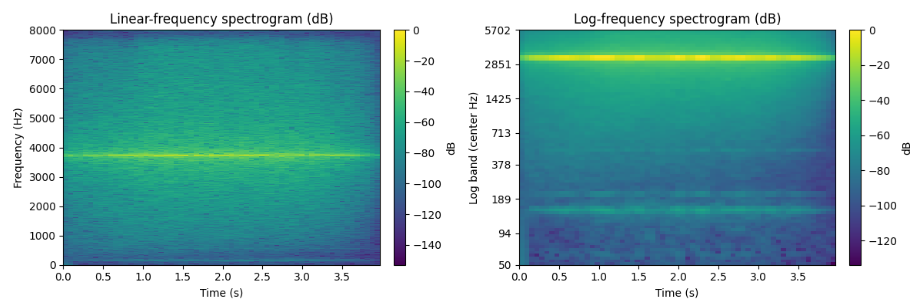

## **2.2**: Training a simple pitch classification model *[1 pt]*
In this section you will train two binary classifiers for a proxy pitch-classification task using the NSynth-subset dataset of high-frequency notes: one using linear spectrograms as features and the other using log-frequency spectrograms.


✏️ For this section, the code is open-ended. Feel free to design helper functions to accomplish each of the requirements below. ✏️

####  ❗**Requirements**❗
- Compute linear and log-frequency spectrograms for the entire dataset to use as features. Use your implementations above. You will also need to use pooling.
- Convert the MIDI labels into binary, with MIDI note **106** as class 1 and all others as 0.
- Split your data into training and testing.
- Min-max normalize your data as discussed in class.
- Train 2 binary classifiers: one using linear and one using log-frequency spectrograms as features. Use logistic regression (can use `sklearn`). The experiments should be as fairly comparable as possible (e.g. train/test splits should match, hyperparameters matching).
- Print the classification accuracy results for each of your two models.
- Complete the written question at the end of the section.

In [ ]:
# ❗ TODO ❗
# ✏️ ✏️ ✏️ Your playground. Open-ended for this section! ✏️ ✏️ ✏️



#### ❗ Written Question❗
**Question:** Which time-frequency representation is more effective for this task and dataset? Why do you think this is the case?
**Your answer:** ❗ TODO ❗

# **Part 3**: Multi-class classification and mel-frequency filterbanks *[1.5 pts]*

### Overview
In this section, you will build on what you've done so far with two added nuances: moving from a binary classification setting to a multi-class setting, for instrument classification, and building a mel filterbank, similar to your log filterbank above but with a different scaling regime.

You will use the same dataset as above, using the first string chunk of each filename (e.g. `flute_acoustic_017-104-050.wav` -> "flute" as the instrument class. Thus, we have three instrument classes: "flute", "mallet", "reed".

## **3.1**: Implementing your Mel-frequency spectrogram *[1 pt]*

#### **Deliverables:**
- Complete `get_mel_filterbank`: compute a Mel-frequency filterbank from scratch.
    - ⚠️ You may use librosa.stft, but beyond that only numpy methods should be used.
- Complete `apply_mel_filterbank`: Apply your Mel filterbank to a linear spectrogram.
- Plot the Mel filterbank.
- Plot a linear vs. log vs. Mel-scaled spectrogram for a sample file in the dataset.

----

A couple of 💡hints💡 for the Mel-frequency spectrogram:
- The structure of this will be very similar to the log-spaced spectrogram above (e.g. use the same triangular windows).
- Use the Mel-scaling formula given in the slides (slides 52-54).
- Do not attempt to exactly match a librosa implementation here. You could use it as a reference point, but there are many nuances in the librosa implementation that will lead to small differences vs. what is presented in the class slides.

In [ ]:
# ❗ TODO ❗

def get_mel_filterbank(
    sr: int,
    n_fft: int,
    n_mels: int = 128,
    fmin: float = 0.0,
    fmax: float | None = None,
    normalize: bool = True,
) -> np.ndarray:
    """
    Create a mel-spaced triangular filterbank.

    Triangular filters are built on the FFT frequency grid and
    optionally area-normalized.

    Args:
        sr (int): Sampling rate (Hz).
        n_fft (int): FFT size (determines number of frequency bins).
        n_mels (int): Number of output mel filters. Default is 128.
        fmin (float): The minimum frequency for the first filter (Hz).
        fmax (float | None): The maximum frequency (Hz). If None, uses sr/2.
        normalize (bool) : If True, normalize each filter to sum to 1.

    Returns:

        F (np.ndarray): Mel filterbank matrix of shape (n_mels, n_fft//2 + 1)
        Note! This returns the filterbank itself, not filterbank applied to a spectrogram.

    """
    F = None
    return F


In [ ]:
# ❗ TODO ❗
def apply_mel_filterbank(F: np.ndarray, power_spec: np.ndarray) -> np.ndarray:
    """
    Apply Mel filterbank to a linear power spectrogram.

    Args:
        F (np.ndarray): Mel filterbank, shape (n_mels, K), where K = n_fft//2 + 1
        power_spec (np.ndarray): linear power spectrogram, shape (K, T)

    returns:
        X_mel (np.ndarray): Mel filterbank applied to power spectrogram. Shape (n_mels, T).

    """
    X_mel = None
    return X_mel

#### Plot your Mel-scaled filterbank
Use the built-in function below to plot your Mel-scaled filterbank. Your plot should have a similar idea as the Mel filterbank image in slide 56 (but will not be exactly the same, this depends on many hyperparameters used).

In [ ]:
# ❗ TODO ❗
# Use the built-in `plot_filterbank` function in 2.1 for this.

### Plot your linear vs. log vs. Mel-frequency spectrograms
Use the built-in function below to check out a sample file across all three scalings using your implementations.

In [ ]:
# BUILT-IN: linear vs. log vs. mel frequency spectrogram plotting
def plot_all_spectrograms(
    audio_path: str,
    *,
    sr: int = 16000,
    n_fft: int = 4096,
    hop_length: int = 1024,
    # --- log filterbank params ---
    B_log: int = 84,
    fmin_log: float = 50.0,
    fmax_log: float | None = None,
    bins_per_octave: int = 12,
    normalize_log_filters: bool = True,
    # --- mel filterbank params ---
    n_mels: int = 128,
    fmin_mel: float = 0.0,
    fmax_mel: float | None = None,
    normalize_mel_filters: bool = True,
):
    """
    Plot three spectrograms side-by-side:
      (1) Linear-frequency spectrogram (STFT power on linear FFT grid)
      (2) Log-frequency spectrogram (apply a log-spaced triangular filterbank)
      (3) Mel-frequency spectrogram (apply a mel-spaced triangular filterbank)

    IMPORTANT:
    - Linear plot y-axis is true frequency in Hz (uniform FFT bins).
    - Log plot is shown in *band index* (rows), but y-ticks are labeled
      using log filter center frequencies in Hz.
    - Mel plot is shown in *mel band index* (rows), but y-ticks are labeled
      using mel filter center frequencies in Hz.

    Requires these functions to already be defined:
        - get_linear_power_spec
        - get_log_filterbank
        - get_mel_filterbank
        - apply_filterbank

    Args:
        audio_path (str): Path to the audio file.
        sr (int): Sampling rate.
        n_fft (int): FFT size / window length for STFT.
        hop_length (int): Hop length for STFT.
        B_log (int): Number of log-frequency bands.
        fmin_log (float): Minimum frequency for log filterbank (Hz).
        fmax_log (float or None): Maximum frequency for log filterbank (Hz). If None, uses sr/2.
        bins_per_octave (int): Controls density of log spacing (12 ~ semitone-like).
        normalize_log_filters (bool): If True, each log filter is area-normalized (sums to 1).
        n_mels (int): Number of mel bands.
        fmin_mel (float): Minimum frequency for mel filterbank (Hz).
        fmax_mel (float or None): Maximum frequency for mel filterbank (Hz). If None, uses sr/2.
        normalize_mel_filters (bool): If True, each mel filter is area-normalized (sums to 1) in your implementation.

    Returns:
        fig (matplotlib.figure.Figure): The created figure.

    """

    if fmax_log is None:
        fmax_log = sr / 2.0
    if fmax_mel is None:
        fmax_mel = sr / 2.0

    # ---------- helpers ----------
    def to_db_power(X, amin=1e-10, ref=1.0):
        X = np.maximum(amin, X)
        return 10.0 * np.log10(X / ref)

    def centers_from_filterbank(F: np.ndarray, freqs_hz: np.ndarray) -> np.ndarray:
        """
        Compute "center frequencies" for each filter row by taking the
        argmax bin and mapping to Hz. (Works well for triangular peaks.)
        """
        peak_bins = np.argmax(F, axis=1)
        return freqs_hz[peak_bins]

    # ---------- load ----------
    y, _ = librosa.load(audio_path, sr=sr)

    # ---------- linear power spectrogram ----------
    # NOTE: call signature assumes your student helper takes (y, n_fft, hop_length)
    S = get_linear_power_spec(y, n_fft, hop_length)  # (K, T)
    K, T = S.shape

    t = np.arange(T) * (hop_length / sr)
    f_lin = np.fft.rfftfreq(n_fft, d=1.0 / sr)

    # ---------- log filterbank + apply ----------
    F_log, log_centers_hz = get_log_filterbank(
        sr=sr,
        n_fft=n_fft,
        B=B_log,
        fmin=fmin_log,
        fmax=fmax_log,
        bins_per_octave=bins_per_octave,
        normalize=normalize_log_filters,
    )
    X_log = apply_filterbank(F_log, S)  # (B_log, T)
    B_log_eff = X_log.shape[0]

    # ---------- mel filterbank + apply ----------
    F_mel = get_mel_filterbank(
        sr=sr,
        n_fft=n_fft,
        n_mels=n_mels,
        fmin=fmin_mel,
        fmax=fmax_mel,
        normalize=normalize_mel_filters,
    )
    X_mel = apply_filterbank(F_mel, S)  # (n_mels_eff, T)
    B_mel_eff = X_mel.shape[0]

    # If your mel filterbank can collapse filters due to bin duplicates,
    # compute centers from the matrix directly to stay consistent.
    mel_centers_hz = centers_from_filterbank(F_mel, f_lin)

    # ---------- display scaling ----------
    S_disp = to_db_power(S, ref=np.max(S))
    X_log_disp = to_db_power(X_log, ref=np.max(X_log))
    X_mel_disp = to_db_power(X_mel, ref=np.max(X_mel))
    cbar_label = "dB"
    suffix = " (dB)"

    # ---------- plot ----------
    fig, ax = plt.subplots(1, 3, figsize=(16, 4), sharex=True)
    cmap = "viridis"

    # (1) linear Hz axis
    im0 = ax[0].imshow(
        S_disp,
        origin="lower",
        aspect="auto",
        extent=[t[0], t[-1], f_lin[0], f_lin[-1]],
        interpolation="nearest",
        cmap=cmap,
    )
    ax[0].set_title("Linear-frequency spectrogram" + suffix)
    ax[0].set_xlabel("Time (s)")
    ax[0].set_ylabel("Frequency (Hz)")
    fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04, label=cbar_label)

    # (2) log band index axis (labeled in Hz)
    im1 = ax[1].imshow(
        X_log_disp,
        origin="lower",
        aspect="auto",
        extent=[t[0], t[-1], 0, B_log_eff - 1],
        interpolation="nearest",
        cmap=cmap,
    )
    ax[1].set_title("Log-frequency spectrogram" + suffix)
    ax[1].set_xlabel("Time (s)")
    ax[1].set_ylabel("Log band (center Hz)")
    num_ticks = 8
    tick_bands = np.linspace(0, B_log_eff - 1, num_ticks).astype(int)
    ax[1].set_yticks(tick_bands)
    ax[1].set_yticklabels([f"{log_centers_hz[i]:.0f}" for i in tick_bands])
    fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04, label=cbar_label)

    # (3) mel band index axis (labeled in Hz)
    im2 = ax[2].imshow(
        X_mel_disp,
        origin="lower",
        aspect="auto",
        extent=[t[0], t[-1], 0, B_mel_eff - 1],
        interpolation="nearest",
        cmap=cmap,
    )
    ax[2].set_title("Mel-frequency spectrogram" + suffix)
    ax[2].set_xlabel("Time (s)")
    ax[2].set_ylabel("Mel band (center Hz)")
    tick_bands_mel = np.linspace(0, B_mel_eff - 1, num_ticks).astype(int)
    ax[2].set_yticks(tick_bands_mel)
    ax[2].set_yticklabels([f"{mel_centers_hz[i]:.0f}" for i in tick_bands_mel])
    fig.colorbar(im2, ax=ax[2], fraction=0.046, pad=0.04, label=cbar_label)

    plt.tight_layout()
    plt.show()

    return fig


In [ ]:
# ❗ TODO ❗ Plot a linear vs. log vs. Mel-frequency spectrogram on a sample file

Below is a sample output to compare to, again using the file `nsynth_high_subset/mallet_electronic_011-106-025.wav` (MIDI 106 = 3729.31 Hz), and the default parameters of the plot function above.
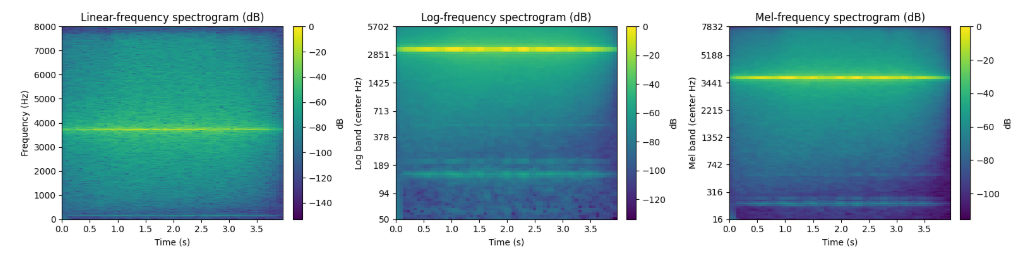

## **3.2**: Training a multi-class instrument classification model *[0.5 pts]*
In this section you will train a multi-class logistic regression model for instrument classification using your Mel-frequency spectrograms as features.

✏️ For this section, the code is open-ended. Feel free to design helper functions to accomplish each of the requirements below. ✏️

####  ❗**Requirements**❗
- Compute Mel-frequency spectrograms for the entire dataset to use as features. Use your implementation above. You will also need to use pooling.
- Convert the instrument labels into numerical labels.
- Split your data into training and testing.
- Min-max normalize your data as discussed in class.
- Train the multi-class logistic regression model.
- Print the per-class classification accuracy and overall accuracy per class.  

In [ ]:
# ❗ TODO ❗
# ✏️ ✏️ ✏️ Your playground. Open-ended for this section! ✏️ ✏️ ✏️

